In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bnk import *

# Structure

## Atom Structure

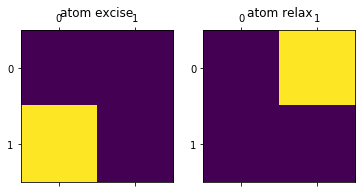

In [2]:
atom_space = Space(2,'atom')

atom_excise = atom_space.eigenstate(1) @ atom_space.eigenstate(0).ct
atom_relax = atom_excise.ct


plt.subplot(1, 2, 1)
plt.matshow(atom_excise.flattened_values, 0)
plt.title("atom excise")

plt.subplot(1, 2, 2)
plt.matshow(atom_relax.flattened_values, 0)
plt.title("atom relax")

plt.show()

## Field Structure

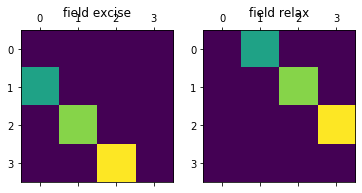

In [3]:
field_space = Space(4, name='field')

field_excise = 0
for i in range(1, field_space.n):
    field_excise_i = field_space.eigenstate(i) @ field_space.eigenstate(i - 1).ct
    field_excise += np.sqrt(i) * field_excise_i
field_relax = field_excise.ct


plt.subplot(1, 2, 1)
plt.matshow(field_excise.flattened_values, 0)
plt.title("field excise")

plt.subplot(1, 2, 2)
plt.matshow(field_relax.flattened_values, 0)
plt.title("field relax")

plt.show()

## Sink Structure

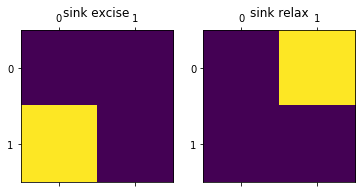

In [4]:
sink_space = Space(2,'sink')

sink_excise = sink_space.eigenstate(1) @ sink_space.eigenstate(0).ct
sink_relax = sink_excise.ct


plt.subplot(1, 2, 1)
plt.matshow(sink_excise.flattened_values, 0)
plt.title("sink excise")

plt.subplot(1, 2, 2)
plt.matshow(sink_relax.flattened_values, 0)
plt.title("sink relax")

plt.show()

# Evolution

## Hamiltonian

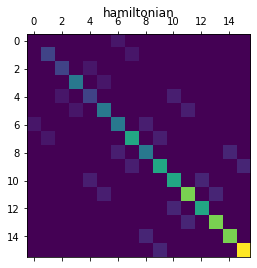

In [5]:
interaction = (
    atom_relax @ field_excise +
    atom_excise @ field_relax +
    atom_excise @ field_excise +
    atom_relax @ field_relax
)

def hamiltonian(hb, w, g):
    return (
    hb * w * atom_excise @ atom_relax  +
    hb * w * field_excise @ field_relax +
    hb * w * sink_excise @ sink_relax +
    g * interaction)


plt.matshow(hamiltonian(1,1,0.3).flattened_values)
plt.title("hamiltonian")
plt.show()

## Evolution

In [6]:
deco = sink_excise @ field_relax

def evolve(rho, hb, w, g, gamma):
    hmt = hamiltonian(hb,w,g)
    deco_ct = deco.ct
    deco_ct_deco = deco_ct @ deco
    return hmt @ rho - rho @ hmt + 1j * gamma*(deco @ rho @ deco_ct - 0.5 * (deco_ct_deco@ rho + rho @ deco_ct_deco))

# Iteration

## Initial $\rho$

<Figure size 432x288 with 0 Axes>

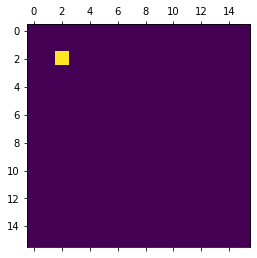

In [7]:
psi0 = field_space.eigenstate(0) \
       @ atom_space.eigenstate(1) \
       @ sink_space.eigenstate(0)
rho0 = psi0 @ psi0.ct


plt.figure()
plt.matshow(rho0.flattened_values)

## Constants

In [8]:
hb = 1
w = 1

g = 0.2  # interaction between atom and field
gamma_list = g*(2 ** np.linspace(0, 4, 5))

## Configurations

In [9]:
dt = 0.001
mt = 50

logs_dt = mt / 200

# Iteration


For gamma = 1.00g (0.0%)
computing...99.73%
For gamma = 2.00g (20.0%)
computing...99.73%
For gamma = 4.00g (40.0%)
computing...99.73%
For gamma = 8.00g (60.0%)
computing...99.73%
For gamma = 16.00g (80.0%)
computing...99.73%

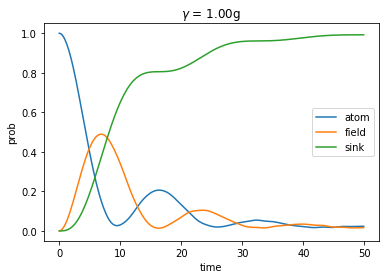

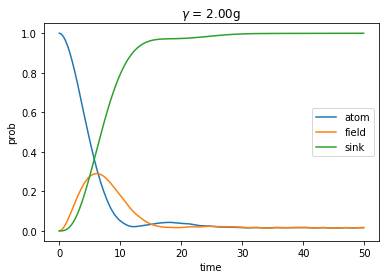

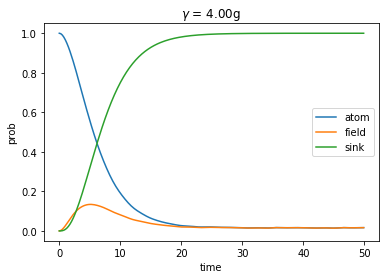

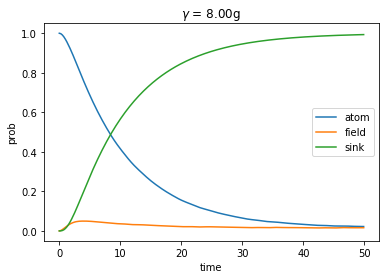

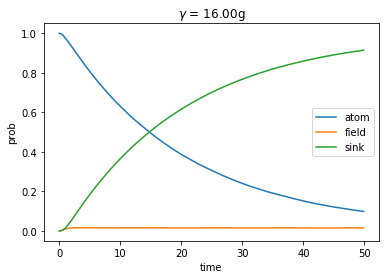

In [10]:
logs_list = []

for i, gamma in enumerate(gamma_list):
    
    print(f"\nFor gamma = {gamma/g:.2f}g ({i/len(gamma_list):.1%})")
    
    t = 0.0
    rho = rho0
    
    logs_t = float('-inf')
    logs = []
    
    while t < mt:
        t += dt
        rho += evolve(rho,hb,w,g,gamma) * (dt/(1j*hb))
        
        if t - logs_t >= logs_dt:
            logs_t = t
            
            rho_atom_field = rho.trace(sink_space)
            rho_atom = rho_atom_field.trace(field_space)
            rho_field = rho_atom_field.trace(atom_space)
            rho_sink = rho.trace(atom_space,field_space)
            
            atom = atom_space.eigenstate(1).ct @ rho_atom @ atom_space.eigenstate(1)
            field = field_space.eigenstate(1).ct @ rho_field @ field_space.eigenstate(1)        
            sink = sink_space.eigenstate(1).ct @ rho_sink @ sink_space.eigenstate(1)
            logs.append((t, atom, field, sink))
            
            print(f"\rcomputing...{t/mt:.2%}", end='')
            
    logs = np.asarray(logs)
    logs_list.append(logs)
    
    logs_ts, logs_atoms, logs_fields, logs_sinks = np.transpose(logs)
    plt.plot(logs_ts, logs_atoms, label='atom')
    plt.plot(logs_ts, logs_fields, label='field')
    plt.plot(logs_ts, logs_sinks, label='sink')
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("prob")
    plt.title(f"$\gamma$ = {gamma/g:.2f}g")
    plt.show()
    plt.close()

logs_list = np.asarray(logs_list)

Text(0.5, 0, 't')

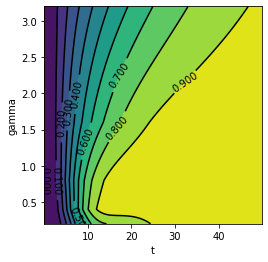

In [18]:
ts = logs_list[0,:,0]
gamma_list = np.asarray(gamma_list)

ts_mesh, gamma_mesh = np.meshgrid(ts, gamma_list, indexing='ij')
sink_mesh = np.transpose(logs_list[:,:,-1])

contour = plt.contour(ts_mesh, gamma_mesh, sink_mesh, 10,colors='black')
plt.clabel(contour, inline=True, fontsize=10)
plt.contourf(ts_mesh, gamma_mesh, sink_mesh, 10)
plt.gca().set_aspect(np.abs((ts[0]-ts[-1])/(gamma_list[0]-gamma_list[-1])))

plt.ylabel("gamma")
plt.xlabel("t")